In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import tensorflow as tf

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
track=pd.read_csv("nfl-big-data-bowl-2022/tracking2018.csv")
plays=pd.read_csv("nfl-big-data-bowl-2022/plays.csv")

In [4]:
plays=plays[plays["specialTeamsResult"]=="Return"]
plays["GamePlayID"]=list(zip(plays["gameId"], plays["playId"]))
track["GamePlayID"]=list(zip(track["gameId"], track["playId"]))
track=track[track["GamePlayID"].isin(plays["GamePlayID"])]
track=track[track["event"]=="kick_received"]
plays=plays[plays["GamePlayID"].isin(track["GamePlayID"])]

In [89]:
track

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection,GamePlayID
52,2018-12-30T21:25:37.400,64.55,26.23,6.29,0.59,0.63,88.91,90.88,kick_received,39470.0,Justin Tucker,9.0,K,home,53,2018123000,36,right,"(2018123000, 36)"
157,2018-12-30T21:25:37.400,80.81,20.81,2.83,3.85,0.29,312.97,21.85,kick_received,40579.0,Ray-Ray Armstrong,52.0,OLB,away,53,2018123000,36,right,"(2018123000, 36)"
262,2018-12-30T21:25:37.400,84.82,13.04,4.36,2.66,0.45,309.48,52.99,kick_received,41316.0,Phillip Gaines,33.0,CB,away,53,2018123000,36,right,"(2018123000, 36)"
367,2018-12-30T21:25:37.400,77.37,35.51,9.00,2.51,0.91,105.69,108.92,kick_received,42398.0,Maxx Williams,87.0,TE,home,53,2018123000,36,right,"(2018123000, 36)"
472,2018-12-30T21:25:37.400,79.07,40.84,9.36,2.45,0.95,102.08,98.79,kick_received,42437.0,Ty Montgomery,88.0,RB,home,53,2018123000,36,right,"(2018123000, 36)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12755727,2018-09-11T04:04:41.300,71.68,14.83,9.40,1.73,0.95,57.67,66.26,kick_received,45341.0,Keon Hatcher,14.0,WR,home,49,2018091001,2216,right,"(2018091001, 2216)"
12755834,2018-09-11T04:04:41.300,71.29,33.27,8.47,2.35,0.85,77.94,74.83,kick_received,45345.0,Nicholas Morrow,50.0,ILB,home,49,2018091001,2216,right,"(2018091001, 2216)"
12755941,2018-09-11T04:04:41.300,84.10,35.82,4.35,4.70,0.46,246.35,99.08,kick_received,46216.0,Micah Kiser,59.0,LB,away,49,2018091001,2216,right,"(2018091001, 2216)"
12756048,2018-09-11T04:04:41.300,80.89,38.70,0.55,2.25,0.09,278.42,4.81,kick_received,46313.0,Justin Lawler,53.0,DE,away,49,2018091001,2216,right,"(2018091001, 2216)"


In [5]:
data=track.groupby(["gameId", "playId"]).agg({"x":lambda x: list(x), "y":lambda x: list(x)})

In [6]:
data

x  \
gameId     playId                                                      
2018090600 677     [53.07, 44.11, 43.9, 39.07, 45.07, 32.17, 50.5...   
           1606    [59.87, 74.78, 71.3, 80.51, 68.87, 87.06, 60.0...   
2018090900 36      [63.9, 45.8, 46.19, 41.51, 45.57, 45.8, 48.81,...   
           400     [83.59, 81.29, 76.95, 83.17, 99.24, 62.85, 82....   
           1992    [35.7, 39.65, 43.19, 35.57, 28.21, 58.02, 36.3...   
...                                                              ...   
2018123015 592     [78.79, 52.95, 68.36, 71.87, 71.29, 69.13, 52....   
           1627    [25.86, 48.71, 40.3, 39.65, 48.59, 41.57, 39.1...   
           1958    [41.15, 67.28, 55.45, 48.57, 60.13, 64.37, 69....   
           2878    [61.74, 30.2, 29.49, 47.51, 46.38, 44.47, 26.9...   
           3287    [96.07, 72.24, 81.62, 80.32, 69.62, 76.67, 84....   

                                                                   y  
gameId     playId                                                     
2018090600 677     [37.21, 24.92, 21.75, 41.27, 49.79, 38.71, 46....  
           1606    [28.52, 44.21, 38.77, 22.18, 13.65, 23.66, 8.5...  
2018090900 36      [32.15, 32.6, 43.97, 28.59, 25.51, 19.61, 23.4...  
           400     [26.5, 31.82, 34.2, 40.74, 31.3, 28.21, 35.45,...  
           1992    [32.52, 33.04, 27.42, 17.53, 36.31, 30.76, 25....  
...                                                              ...  
2018123015 592     [37.32, 40.81, 34.59, 23.37, 31.9, 26.65, 40.0...  
           1627    [32.28, 37.08, 38.88, 28.6, 18.25, 19.7, 33.67...  
           1958    [39.2, 28.19, 21.62, 35.66, 31.92, 48.6, 27.47...  
           2878    [17.81, 19.53, 9.48, 33.94, 25.95, 15.21, 16.0...  
           3287    [24.29, 13.78, 12.62, 26.08, 32.92, 37.84, 19....  

[981 rows x 2 columns]

In [134]:
plays["returnerId"]

3       44979
9       44979
24      46532
26      42573
39      42573
        ...  
6789    43406
6797    42412
6801    43406
6808    46203
6811    42412
Name: returnerId, Length: 963, dtype: object

In [123]:
plays["playDescription"][3]

'M.Bosher kicks 64 yards from ATL 35 to PHI 1. S.Gibson to PHI 31 for 30 yards (D.Kazee, D.Riley).'

In [132]:
import re
re.findall(" [A-Z]\.([A-Z].*?) " , plays["playDescription"][3])

['Gibson']

In [111]:
plays["Receiver"]=plays["playDescription"].map(lambda x: re.findall(" [A-Z].+\.([A-Z].+?) ", x)[-1] if len(re.findall(" [A-Z].+\.([A-Z].+?) ", x))>=1 else 0)

In [120]:
plays=plays[plays["Receiver"]!=0]
plays["Receiver"]=plays["Receiver"].map(lambda x: x[:-1] if x[-1]=="," else x)

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [121]:
plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,GamePlayID,Receiver
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,NaN,0,3,NaN,64.0,30.0,34,75,"(2018090600, 677)",Kazee
9,2018090600,1606,M.Bosher kicks 68 yards from ATL 35 to PHI -3....,2,0,0,ATL,Kickoff,Return,37267.0,...,5.0,3,6,NaN,68.0,13.0,60,45,"(2018090600, 1606)",Maddox
24,2018090900,36,S.Hauschka kicks 69 yards from BUF 35 to BAL -...,1,0,0,BUF,Kickoff,Return,33469.0,...,0.0,0,0,NaN,69.0,24.0,45,75,"(2018090900, 36)",Pitts
26,2018090900,400,J.Tucker kicks 61 yards from BAL 35 to BUF 4. ...,1,0,0,BAL,Kickoff,Return,39470.0,...,NaN,7,0,NaN,61.0,28.0,33,45,"(2018090900, 400)",Murphy
39,2018090900,1992,J.Tucker kicks 65 yards from BAL 35 to BUF 0. ...,2,0,0,BAL,Kickoff,Return,39470.0,...,NaN,20,0,NaN,65.0,25.0,40,75,"(2018090900, 1992)",Murphy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6789,2018123015,592,"(5:35) M.Dickson punts 46 yards to ARI 34, Cen...",1,4,14,SEA,Punt,Return,46218.0,...,NaN,0,3,NaN,46.0,5.0,41,90,"(2018123015, 592)",Mingo
6797,2018123015,1627,Z.Gonzalez kicks 64 yards from ARI 35 to SEA 1...,2,0,0,ARI,Kickoff,Return,45037.0,...,NaN,14,10,NaN,64.0,15.0,49,75,"(2018123015, 1627)",Lockett
6801,2018123015,1958,"(:57) M.Dickson punts 42 yards to ARI 33, Cent...",2,4,10,SEA,Punt,Return,46218.0,...,NaN,14,13,NaN,42.0,3.0,39,35,"(2018123015, 1958)",Cooper
6808,2018123015,2878,S.Janikowski kicks 53 yards from SEA 35 to ARI...,3,0,0,SEA,Kickoff,Return,25326.0,...,NaN,21,13,NaN,53.0,18.0,35,75,"(2018123015, 2878)",Edmonds


In [112]:
plays[plays["Receiver"]==0] #Discard 18 samples not captured

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,GamePlayID,Receiver
2443,2018101412,2006,S.Gostkowski kicks 64 yards from NE 35 to KC 1...,3,0,0,NE,Kickoff,Return,30932.0,...,NaN,24,9,NaN,64.0,24.0,40,75,"(2018101412, 2006)",0
2453,2018101412,3195,S.Gostkowski kicks 65 yards from NE 35 to KC 0...,4,0,0,NE,Kickoff,Return,30932.0,...,NaN,30,26,NaN,65.0,97.0,-32,45,"(2018101412, 3195)",0
2660,2018102105,1681,R.Bullock kicks 65 yards from CIN 35 to KC 0. ...,2,0,0,CIN,Kickoff,Return,38691.0,...,NaN,14,7,NaN,65.0,23.0,42,75,"(2018102105, 1681)",0
3046,2018102805,447,B.McManus kicks 61 yards from DEN 35 to KC 4. ...,1,0,0,DEN,Kickoff,Return,40276.0,...,NaN,0,7,NaN,61.0,33.0,28,45,"(2018102805, 447)",0
3056,2018102805,2014,B.McManus kicks 67 yards from DEN 35 to KC -2....,2,0,0,DEN,Kickoff,Return,40276.0,...,NaN,16,14,NaN,67.0,20.0,47,75,"(2018102805, 2014)",0
3378,2018110403,754,G.Joseph kicks 59 yards from CLE 35 to KC 6. T...,1,0,0,CLE,Kickoff,Return,46634.0,...,NaN,3,7,NaN,59.0,19.0,40,75,"(2018110403, 754)",0
3384,2018110403,1983,G.Joseph kicks 64 yards from CLE 35 to KC 1. T...,2,0,0,CLE,Kickoff,Return,46634.0,...,NaN,15,21,NaN,64.0,34.0,30,45,"(2018110403, 1983)",0
3767,2018111105,36,P.Dawson kicks 55 yards from ARI 35 to KC 10. ...,1,0,0,ARI,Kickoff,Return,23860.0,...,NaN,0,0,NaN,55.0,15.0,40,75,"(2018111105, 36)",0
3784,2018111105,2372,P.Dawson kicks 59 yards from ARI 35 to KC 6. T...,3,0,0,ARI,Kickoff,Return,23860.0,...,NaN,20,14,NaN,59.0,7.0,52,75,"(2018111105, 2372)",0
4301,2018111900,309,G.Zuerlein kicks 64 yards from LA 35 to KC 1. ...,1,0,0,LA,Kickoff,Return,38701.0,...,NaN,6,0,NaN,64.0,28.0,36,75,"(2018111900, 309)",0


In [7]:
dataset=np.array([np.array(list(data["x"])), np.array(list(data["y"]))])

In [8]:
dataset=dataset.reshape((981,23,2))

In [9]:
y=plays["kickReturnYardage"]

Error:  13.142942382173826


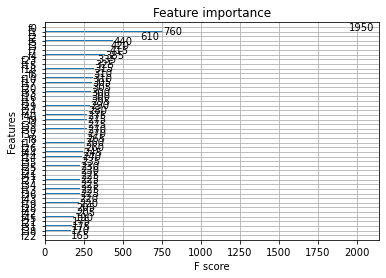

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

first_train, first_test, y_train, y_test=train_test_split(dataset.reshape(981,46), y, test_size=.2, random_state=1)

data_matrix=xgb.DMatrix(data=dataset.reshape(981,46), label=y)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, num_parallel_tree=5,
                max_depth = 6, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=1)

xg_reg.fit(first_train, y_train)

xgb.plot_importance(xg_reg)

pred=xg_reg.predict(first_test)

print("Error: ", np.sqrt(mean_squared_error(y_test, pred)))

In [11]:
data["x"]

gameId      playId
2018090600  677       [53.07, 44.11, 43.9, 39.07, 45.07, 32.17, 50.5...
            1606      [59.87, 74.78, 71.3, 80.51, 68.87, 87.06, 60.0...
2018090900  36        [63.9, 45.8, 46.19, 41.51, 45.57, 45.8, 48.81,...
            400       [83.59, 81.29, 76.95, 83.17, 99.24, 62.85, 82....
            1992      [35.7, 39.65, 43.19, 35.57, 28.21, 58.02, 36.3...
                                            ...                        
2018123015  592       [78.79, 52.95, 68.36, 71.87, 71.29, 69.13, 52....
            1627      [25.86, 48.71, 40.3, 39.65, 48.59, 41.57, 39.1...
            1958      [41.15, 67.28, 55.45, 48.57, 60.13, 64.37, 69....
            2878      [61.74, 30.2, 29.49, 47.51, 46.38, 44.47, 26.9...
            3287      [96.07, 72.24, 81.62, 80.32, 69.62, 76.67, 84....
Name: x, Length: 981, dtype: object

In [12]:
second=dataset.copy()
for i in range(23):
    for j in range(23):
        if i!=j:
            second=np.concatenate([second,second[:,i:i+1,:]-second[:,j:j+1,:]], axis=1)

In [13]:
second.shape

(981, 529, 2)

In [14]:
second_train, second_test, y_train, y_test=train_test_split(second.reshape(981,1058), y, test_size=.2, random_state=1)

data_matrix=xgb.DMatrix(data=dataset.reshape(981,46), label=y)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, num_parallel_tree=5,
                max_depth = 6, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=1)

xg_reg.fit(second_train, y_train)

#xgb.plot_importance(xg_reg)

pred=xg_reg.predict(second_test)

print("Error: ", np.sqrt(mean_squared_error(y_test, pred)))

Error:  13.027769583093606


In [15]:
third=dataset.copy()
for i in range(22):
    third=np.concatenate([third,third[:,i:i+1,:]-third[:,22:23,:]], axis=1)

In [16]:
third.shape

(981, 45, 2)

In [26]:
third_train, third_test, y_train, y_test=train_test_split(third.reshape(981,90), y, test_size=.2, random_state=1)

data_matrix=xgb.DMatrix(data=dataset.reshape(981,46), label=y)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, num_parallel_tree=5,
                max_depth = 6, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=1)

xg_reg.fit(third_train, y_train)

#xgb.plot_importance(xg_reg)

pred=xg_reg.predict(third_test)

print("Error: ", np.sqrt(mean_squared_error(y_test, pred)))

Error:  13.368091366658408


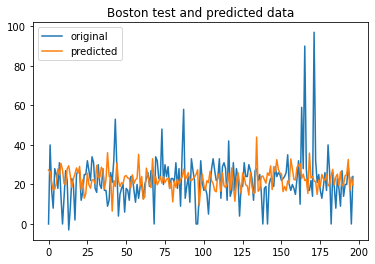

In [27]:
import matplotlib.pyplot as plt
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, pred, label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()

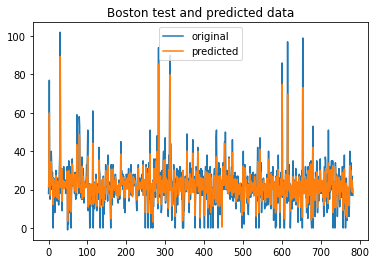

In [ ]:
x_ax = range(len(y_train))
plt.plot(x_ax, y_train, label="original")
plt.plot(x_ax, xg_reg.predict(first_train), label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()

[17:40:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuaracy:  0.7563451776649747
F1:  0.8604651162790699
ROC:  0.4838375796178344


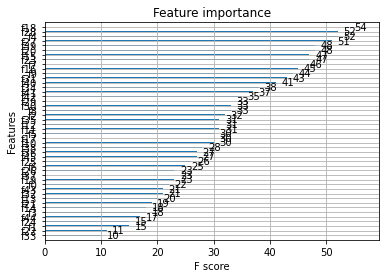

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

first_train, first_test, y_train, y_test=train_test_split(dataset.reshape(981,46), (y>=15).astype(int), test_size=.2, random_state=1)

data_matrix=xgb.DMatrix(data=dataset.reshape(981,46), label=(y>=20).astype(int))

xg_reg = xgb.XGBClassifier(use_label_encoder=False, objective ='binary:logistic', learning_rate = 0.2, num_parallel_tree=1,
                max_depth = 6, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=1)

xg_reg.fit(first_train, y_train)

xgb.plot_importance(xg_reg)

pred=xg_reg.predict(first_test)

print("Accuaracy: ", (y_test==pred).sum()/len(y_test))
print("F1: ", f1_score(y_test, pred))
print("ROC: ", roc_auc_score(y_test, pred))

In [20]:
xg_reg.feature_importances_

array([0.02999635, 0.01520343, 0.01322583, 0.01132362, 0.02452511,
       0.01347932, 0.01939294, 0.03055447, 0.02157834, 0.02015505,
       0.02373289, 0.02584448, 0.01652269, 0.01751494, 0.01722291,
       0.02259003, 0.02394139, 0.02828184, 0.01772855, 0.0254644 ,
       0.0351066 , 0.02169982, 0.01540251, 0.02840617, 0.02666092,
       0.0254962 , 0.00954699, 0.0216905 , 0.01659833, 0.01753975,
       0.02031528, 0.01820162, 0.01930663, 0.02364007, 0.04289623,
       0.01665031, 0.01098799, 0.02680672, 0.01588193, 0.02526621,
       0.02631172, 0.03127922, 0.03310303, 0.01132433, 0.02206639,
       0.01953607], dtype=float32)

In [71]:
second_train, second_test, y_train, y_test=train_test_split(second.reshape(981,1058), (y>=15).astype(int), test_size=.2, random_state=1)

xg_reg = xgb.XGBClassifier(use_label_encoder=False, objective ='binary:logistic', learning_rate = 0.2, num_parallel_tree=1,
                max_depth = 10, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=0.05)

xg_reg.fit(second_train, y_train)

#xgb.plot_importance(xg_reg)

pred=xg_reg.predict(second_test)

print("Accuaracy: ", (y_test==pred).sum()/len(y_test))
print("F1: ", f1_score(y_test, pred))
print("ROC: ", roc_auc_score(y_test, pred))

[17:57:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuaracy:  0.7918781725888325
F1:  0.8831908831908832
ROC:  0.5061305732484077


In [63]:
xg_reg.feature_importances_

array([0.00284075, 0.00345815, 0.        , ..., 0.00217424, 0.00027055,
       0.00027184], dtype=float32)

[17:57:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuaracy:  0.7360406091370558
F1:  0.8470588235294118
ROC:  0.4876907572703714


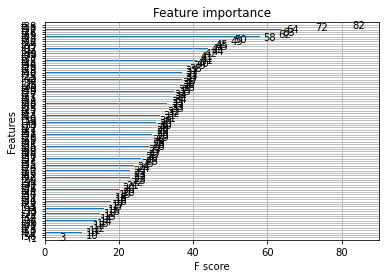

In [74]:
third_train, third_test, y_train, y_test=train_test_split(third.reshape(981,90), (y>=17).astype(int), test_size=.2, random_state=1)

data_matrix=xgb.DMatrix(data=dataset.reshape(981,46), label=(y>=20))

xg_reg = xgb.XGBClassifier(use_label_encoder=False, objective ='binary:logistic', learning_rate = 0.2, num_parallel_tree=1,
                max_depth = 12, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=.1)

xg_reg.fit(third_train, y_train)

xgb.plot_importance(xg_reg)

pred=xg_reg.predict(third_test)

print("Accuaracy: ", (y_test==pred).sum()/len(y_test))
print("F1: ", f1_score(y_test, pred))
print("ROC: ", roc_auc_score(y_test, pred))

In [75]:
xg_reg.feature_importances_

array([0.00603506, 0.0021901 , 0.01811775, 0.00298446, 0.00412463,
       0.0050502 , 0.0138635 , 0.02571552, 0.01587936, 0.00833095,
       0.00579847, 0.0027502 , 0.00423189, 0.01081961, 0.0071405 ,
       0.02259964, 0.01071594, 0.01154801, 0.01464297, 0.00853467,
       0.01025781, 0.00378548, 0.00920858, 0.00742246, 0.00936999,
       0.01287678, 0.0107557 , 0.016648  , 0.00511792, 0.00691683,
       0.01956744, 0.00281753, 0.0087972 , 0.01156687, 0.02566094,
       0.01517978, 0.02167688, 0.00622401, 0.00478358, 0.02565003,
       0.01284568, 0.01150603, 0.01150109, 0.00336053, 0.01059076,
       0.01125356, 0.01506033, 0.01838298, 0.00807996, 0.01152433,
       0.0163958 , 0.01142676, 0.00794778, 0.01489622, 0.0070601 ,
       0.00923182, 0.00667645, 0.01092397, 0.01478163, 0.00639578,
       0.00719006, 0.00758433, 0.01813499, 0.01065096, 0.02725379,
       0.00459382, 0.0170303 , 0.0120861 , 0.01874088, 0.00660167,
       0.01789373, 0.01357393, 0.01329836, 0.00687808, 0.01290